# Fist Gesture Recognition
This jupyter notebook has been used to generate and train the fist gesture recognition neural network.

In [1]:
#installation of libraries and packages if needed
%pip install imageio
%pip install scikit-image
%pip install matplotlib
%pip install tensorflow
%pip install keras #high level API for tensorflow
%pip install pandas
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Libraries

In [ ]:
#Importing libraries

import numpy as np
import os
import random as rn
import warnings
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import imageio
from imageio.v2 import imread
from skimage.transform import resize


import tensorflow as tf
import keras
from keras import backend as K

import cv2
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

## Settings

In [ ]:
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [4]:
print(tf.__version__)
print(keras.__version__)

2.19.0
3.9.2


In [5]:
np.random.seed(30)
rn.seed(30)
seed = tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity.

In [ ]:
#Andrea's path
#model = Path('/Users/andreaarosio/OneDrive - Politecnico di Milano/POLI/2 anno/1 semestre/Creative Programming/HACKATON/Codici interessanti/Rete neurale per movimenti/DS1_FIST')

#Filippo's path
model = Path('/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Creative Programming and Computing ⌨️/HACKATON/Codici interessanti/Rete neurale per movimenti/DS1_FIST')

train_doc = np.random.permutation((model / 'train/train.csv').read_text().splitlines())
val_doc = np.random.permutation((model / 'valid/val.csv').read_text().splitlines())

batch_size = 32 # size of the batch
num_classes = 2 # number of classes

print(f'Train length: {len(train_doc)}')
print(f'Validation length: {len(val_doc)}')

Train length: 3442
Validation length: 216


## Generator
In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch.

In [7]:
def preprocess_image(image, channel, height, width):
    image = resize_image(image, height, width)
    return normalise_image(image, channel)

In [8]:
def normalise_image(image, channel):
    return (image[...,channel])/255

In [9]:
def resize_image(image, height, width):
    h, w, c = image.shape
    return resize(image, (height, width), anti_aliasing=True)

In [10]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

In [ ]:
def generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    """
    Generates a batch of data for training or validation.
    Args:
        t (list): List of training or validation data.
        source_path (str): Path to the source images.
        batch_size (int): Size of the batch.
        img_idx (list): Indices of images to be used in the batch.
        batch (int): Current batch number.
        batch_data (np.ndarray): Array to hold the batch data.
        batch_labels (np.ndarray): Array to hold the batch labels.
        height (int, optional): Height of the resized images. Defaults to 120.
        width (int, optional): Width of the resized images. Defaults to 120.
        augment (bool, optional): Whether to apply data augmentation. Defaults to False.
    Returns:
        tuple: A tuple containing the batch data and batch labels.
    """

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            

            # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
            if augment:
                image = resize_image(image, height, width)
                if np.random.randn() > 0:
                    image = datagen.random_transform(image) #random transformation of the image to augment the dataset dimension                   

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            
            batch_data[folder,idx,:,:,0] = preprocess_image(image, 0, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = preprocess_image(image, 1, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = preprocess_image(image, 2, height, width) #normalise and feed in the image                  
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
def extract_common_name(filename):
    """
    It extracts the common part of the filename before '_jpg' and returns it.
    Args:
        filename (str): The name of the file.
    Returns:
        str: The common part of the filename.
    """
    parts = filename.split("_jpg")  # it splits the filename at '_jpg'
    if len(parts) > 1:
        return "jpg" + parts[1]  # it reconstructs the common part keeping 'jpg'
    return filename  # In case of error, it returns the original name

def load_labels(csv_path):
    """
    Loads the CSV file and creates a dictionary {common_part: label_index}.
    Args:
        csv_path (str): The path to the CSV file.
    Returns:
        dict: A dictionary mapping common parts of filenames to their label indices.
    """
    df = pd.read_csv(csv_path)
    label_map = {"open": 0, "fist": 1}  # Mapping of class names to indices

    labels_dict = {}
    for _, row in df.iterrows():
        common_name = extract_common_name(row["filename"])  # it normalizes the name
        labels_dict[common_name] = label_map[row["class"]]  # it assigns the class

    return labels_dict


def generate(source_path, csv_path, batch_size, height=120, width=120, augment=False):
    labels_dict = load_labels(csv_path)
    image_list = os.listdir(source_path)
    valid_images = [img for img in image_list if extract_common_name(img) in labels_dict]

    while True:
        np.random.shuffle(valid_images)
        num_batches = len(valid_images) // batch_size

        for batch in range(num_batches + 1):
            start = batch * batch_size
            end = min((batch + 1) * batch_size, len(valid_images))
            batch_files = valid_images[start:end]

            batch_data = np.zeros((len(batch_files), height, width, 3))  # 3 channels for RGB
            batch_labels = np.zeros((len(batch_files), 2))  # 2 classes

            for i, file in enumerate(batch_files):
                img = cv2.imread(os.path.join(source_path, file))
                img = cv2.resize(img, (width, height))
                batch_data[i] = img / 255.0  # Normalizes the pixel values

                common_name = extract_common_name(file)
                label = labels_dict[common_name]
                batch_labels[i] = to_categorical(label, num_classes=2)

            yield batch_data, batch_labels

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = str(model / "train")
val_path = str(model/ "valid")

train_doc = str(model / "train" / "train.csv")
val_doc = str(model / "valid" / "val.csv")

batch_size = 32

train_gen = generate(train_path, train_doc, batch_size)
val_gen = generate(val_path, val_doc, batch_size)


num_train_sequences = len(train_doc)

print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs, the order of the sum
print ('# epochs =', num_epochs)

# training sequences = 189
# validation sequences = 187
# epochs = 20


#### Validating the Generator

In [14]:
# check complete batch shape
sample_generator = generate(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generate(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

(32, 120, 120, 3)
(32, 120, 120, 3)


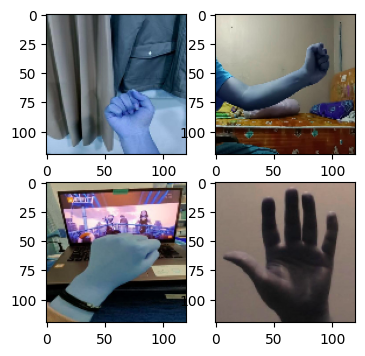

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0,0].imshow(sample_batch_data[17])  # Seleziona immagine 16
ax[0,1].imshow(sample_batch_data[22])  # Seleziona immagine 25

ax[1,0].imshow(sample_val_batch_data[11])  # Seleziona immagine 16 dal validation set
ax[1,1].imshow(sample_val_batch_data[21])  # Seleziona immagine 25 dal validation set

plt.show()


## Model
Here you make the model using different functionalities that Keras provides.

Model callback utility

In [17]:
def plot_loss_accuracy(history):
    print("Chiavi disponibili in history:", history.history.keys())  # DEBUG

    # Controllo se usare accuracy o categorical_accuracy
    accuracy_key = 'accuracy' if 'accuracy' in history.history else 'categorical_accuracy'
    val_accuracy_key = 'val_' + accuracy_key

    # Plot accuracy
    plt.plot(history.history[accuracy_key])
    plt.plot(history.history[val_accuracy_key])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [18]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) 

    return [checkpoint, LR]


In [19]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [20]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Model 1: 
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [21]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 60  #experiment with the batch size
print ('# batch size =', batch_size)

model = conv3D()

print (model.summary())

# epochs = 20
# batch size = 60


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 20, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 60, 60, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 60, 60, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 15, 15, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,933,378 (7.38 MB)

 Trainable params: 1,932,130 (7.37 MB)

 Non-trainable params: 1,248 (4.88 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
callbacks_list = model_callbacks("model_30_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Modifica da Conv3D a Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Due classi (open e fist)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5288 - loss: 6.2975
Epoch 1: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00001-7.38476-0.48750-1.80667-0.75598.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.5206 - loss: 6.5150 - val_accuracy: 0.7560 - val_loss: 1.8067 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5045 - loss: 4.3028
Epoch 2: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00002-3.45841-0.50417-3.50680-0.25837.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5044 - loss: 4.1339 - val_accuracy: 0.2584 - val_loss: 3.5068 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4993 - loss: 1.9235
Epoch 3: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00003-1.70699-0.51667-0.55011-0.67464.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5028 - loss: 1.8802 - val_accuracy: 0.6746 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6108 - loss: 0.7083
Epoch 4: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00004-0.74402-0.57083-0.50559-0.71292.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6028 - loss: 0.7154 - val_accuracy: 0.7129 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6062 - loss: 0.7265
Epoch 5: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00005-0.72051-0.59167-1.17463-0.30622.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6033 - loss: 0.7253 - val_accuracy: 0.3062 - val_loss: 1.1746 - learning_rate: 0.0010
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5455 - loss: 0.7171
Epoch 6: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00006-0.66721-0.58750-0.51386-0.73206.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5539 - loss: 0.7071 - val_accuracy: 0.7321 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6187 - loss: 0.6401
Epoch 7: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00007-0.60769-0.64167-0.76936-0.58373.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6233 - loss: 0.6336 - val_accuracy: 0.5837 - val_loss: 0.7694 - learning_rate: 0.0010
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7424 - loss: 0.5484
Epoch 8: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00008-0.57070-0.71667-0.76896-0.58373.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7372 - loss: 0.5529 - val_accuracy: 0.5837 - val_loss: 0.7690 - learning_rate: 1.0000e-04
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7431 - loss: 0.5500
Epoch 9: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00009-0.57236-0.72500-0.70418-0.59330.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7394 - loss: 0.5544 - val_accuracy: 0.5933 - val_loss: 0.7042 - learning_rate: 1.0000e-04
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7684 - loss: 0.5417
Epoch 10: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00010-0.54363-0.74583-0.62959-0.66986.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7639 - loss: 0.5421 - val_accuracy: 0.6699 - val_loss: 0.6296 - learning_rate: 1.0000e-04
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7174 - loss: 0.5450
Epoch 11: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00011-0.54275-0.72500-0.57408-0.69378.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7189 - loss: 0.5446 - val_accuracy: 0.6938 - val_loss: 0.5741 - learning_rate: 1.0000e-04
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6981 - loss: 0.5581
Epoch 12: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00012-0.54073-0.72678-0.58305-0.68421.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7038 - loss: 0.5546 - val_accuracy: 0.6842 - val_loss: 0.5830 - learning_rate: 1.0000e-04
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8163 - loss: 0.5119
Epoch 13: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00013-0.50467-0.81250-0.60471-0.66986.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8156 - loss: 0.5105 - val_accuracy: 0.6699 - val_loss: 0.6047 - learning_rate: 1.0000e-04
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7406 - loss: 0.5361
Epoch 14: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00014-0.52662-0.74583-0.61164-0.65550.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7417 - loss: 0.5342 - val_accuracy: 0.6555 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7858 - loss: 0.4875
Epoch 15: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00015-0.48051-0.78750-0.59793-0.65550.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7861 - loss: 0.4861 - val_accuracy: 0.6555 - val_loss: 0.5979 - learning_rate: 1.0000e-04
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7719 - loss: 0.5183
Epoch 16: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00016-0.51404-0.78750-0.53585-0.71292.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7750 - loss: 0.5174 - val_accuracy: 0.7129 - val_loss: 0.5358 - learning_rate: 1.0000e-04
Epoch 17/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7740 - loss: 0.4654
Epoch 17: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00017-0.48790-0.77083-0.52328-0.71770.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7733 - loss: 0.4699 - val_accuracy: 0.7177 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 18/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7986 - loss: 0.4876
Epoch 18: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00018-0.50487-0.77500-0.53275-0.71292.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7939 - loss: 0.4911 - val_accuracy: 0.7129 - val_loss: 0.5328 - learning_rate: 1.0000e-04
Epoch 19/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8090 - loss: 0.4487
Epoch 19: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00019-0.45649-0.80000-0.57970-0.68900.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8072 - loss: 0.4503 - val_accuracy: 0.6890 - val_loss: 0.5797 - learning_rate: 1.0000e-04
Epoch 20/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7660 - loss: 0.5008
Epoch 20: saving model to model_30_conv3D_1_2025-05-05_21-13-04/model-00020-0.49815-0.77500-0.61645-0.69856.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7678 - loss: 0.5003 - val_accuracy: 0.6986 - val_loss: 0.6164 - learning_rate: 1.0000e-04


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


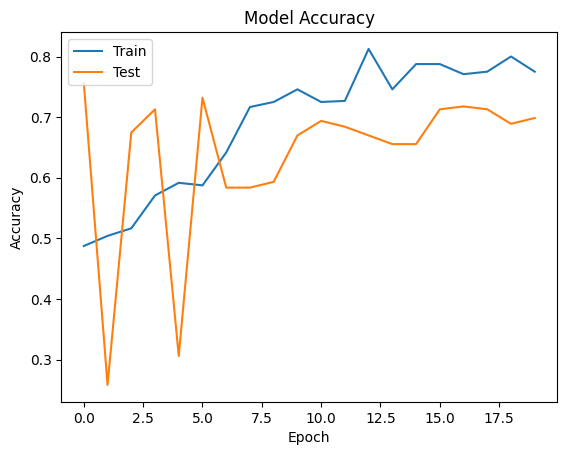

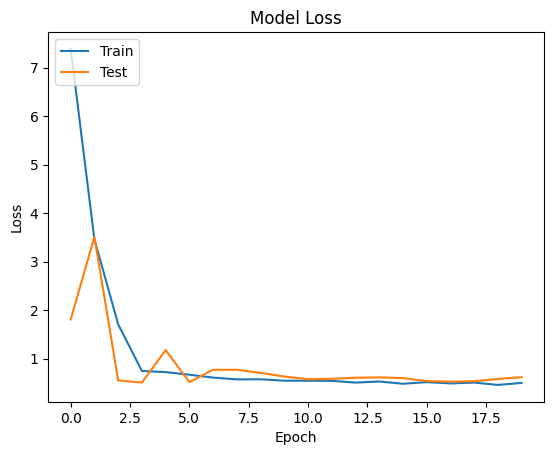

In [25]:
plot_loss_accuracy(history)

#### Model 2: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Creazione del modello
model = Sequential()

# Primo layer Conv2D
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120, 120, 3)))  # Primo layer con 16 filtri
model.add(MaxPooling2D((2, 2)))  # MaxPooling per ridurre le dimensioni

# Secondo layer Conv2D
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Terzo layer Conv2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Quarto layer Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten per passare ai layer densi
model.add(Flatten())

# Primo layer denso
model.add(Dense(256, activation='relu'))

# Secondo layer denso
model.add(Dense(128, activation='relu'))

# Layer di output con 2 classi (fist e open)
model.add(Dense(2, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Riepilogo del modello
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 950,050 (3.62 MB)

 Trainable params: 950,050 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  


In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=num_epochs, 
    verbose=1,        
    callbacks=callbacks_list, 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    initial_epoch=0
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4870 - loss: 0.6936
Epoch 1: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00001-0.69580-0.47778-0.65354-0.75000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.4847 - loss: 0.6942 - val_accuracy: 0.7500 - val_loss: 0.6535 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5269 - loss: 0.7034
Epoch 2: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00002-0.70606-0.52222-0.67775-0.76667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.5257 - loss: 0.7041 - val_accuracy: 0.7667 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6056 - loss: 0.6867
Epoch 3: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00003-0.68758-0.58333-0.73261-0.24444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6000 - loss: 0.6869 - val_accuracy: 0.2444 - val_loss: 0.7326 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5472 - loss: 0.6837
Epoch 4: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00004-0.68697-0.50000-0.72621-0.33557.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5354 - loss: 0.6845 - val_accuracy: 0.3356 - val_loss: 0.7262 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5704 - loss: 0.6777
Epoch 5: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00005-0.67907-0.59444-0.72495-0.36667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5764 - loss: 0.6781 - val_accuracy: 0.3667 - val_loss: 0.7249 - learning_rate: 1.0000e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6157 - loss: 0.6801
Epoch 6: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00006-0.67807-0.63889-0.71986-0.43889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6215 - loss: 0.6796 - val_accuracy: 0.4389 - val_loss: 0.7199 - learning_rate: 1.0000e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6824 - loss: 0.6673
Epoch 7: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00007-0.66744-0.67222-0.72909-0.40940.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6799 - loss: 0.6673 - val_accuracy: 0.4094 - val_loss: 0.7291 - learning_rate: 1.0000e-04
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6389 - loss: 0.6781 
Epoch 8: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00008-0.67484-0.66667-0.73318-0.40000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.4000 - val_loss: 0.7332 - learning_rate: 1.0000e-04
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6000 - loss: 0.6731
Epoch 9: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00009-0.67468-0.60000-0.73748-0.42778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6000 - loss: 0.6735 - val_accuracy: 0.4278 - val_loss: 0.7375 - learning_rate: 1.0000e-04
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6296 - loss: 0.6595
Epoch 10: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00010-0.66750-0.60556-0.72855-0.44444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6236 - loss: 0.6615 - val_accuracy: 0.4444 - val_loss: 0.7285 - learning_rate: 1.0000e-04
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7093 - loss: 0.6585
Epoch 11: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00011-0.65774-0.69444-0.74629-0.41611.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7056 - loss: 0.6583 - val_accuracy: 0.4161 - val_loss: 0.7463 - learning_rate: 1.0000e-04
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6296 - loss: 0.6576
Epoch 12: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00012-0.66084-0.62222-0.76625-0.38889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6278 - loss: 0.6584 - val_accuracy: 0.3889 - val_loss: 0.7662 - learning_rate: 1.0000e-04
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6111 - loss: 0.6610
Epoch 13: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00013-0.64552-0.65000-0.76455-0.38333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6208 - loss: 0.6571 - val_accuracy: 0.3833 - val_loss: 0.7646 - learning_rate: 1.0000e-04
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6602 - loss: 0.6636
Epoch 14: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00014-0.65861-0.67222-0.76738-0.43333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6632 - loss: 0.6624 - val_accuracy: 0.4333 - val_loss: 0.7674 - learning_rate: 1.0000e-04
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6741 - loss: 0.6659
Epoch 15: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00015-0.66118-0.67222-0.72433-0.46309.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6736 - loss: 0.6648 - val_accuracy: 0.4631 - val_loss: 0.7243 - learning_rate: 1.0000e-04
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7724 - loss: 0.6199
Epoch 16: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00016-0.62030-0.75610-0.74124-0.45000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7683 - loss: 0.6200 - val_accuracy: 0.4500 - val_loss: 0.7412 - learning_rate: 1.0000e-04
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6009 - loss: 0.6684
Epoch 17: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00017-0.67252-0.59444-0.76676-0.43889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5993 - loss: 0.6694 - val_accuracy: 0.4389 - val_loss: 0.7668 - learning_rate: 1.0000e-04
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7065 - loss: 0.6234
Epoch 18: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00018-0.62518-0.69444-0.76302-0.44444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7035 - loss: 0.6239 - val_accuracy: 0.4444 - val_loss: 0.7630 - learning_rate: 1.0000e-04
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6120 - loss: 0.6499
Epoch 19: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00019-0.63198-0.66111-0.69161-0.48993.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6243 - loss: 0.6455 - val_accuracy: 0.4899 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7546 - loss: 0.6125
Epoch 20: saving model to model_Conv2D_2_2025-05-05_21-13-15/model-00020-0.61471-0.72222-0.69961-0.48333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7465 - loss: 0.6130 - val_accuracy: 0.4833 - val_loss: 0.6996 - learning_rate: 1.0000e-04


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


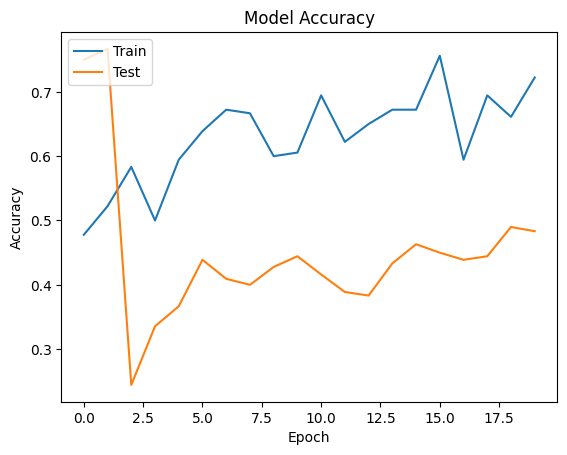

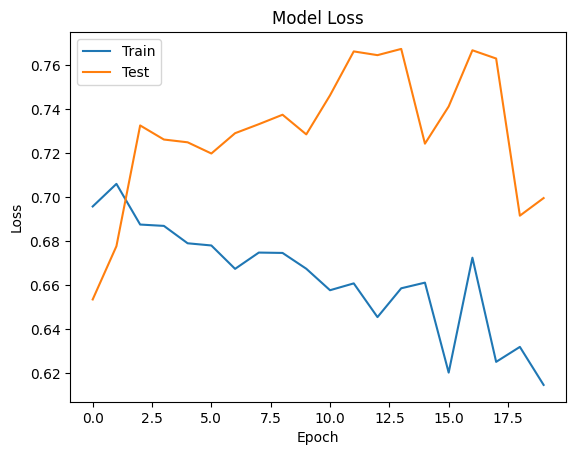

In [29]:
plot_loss_accuracy(history)

#### Model 3: 
Conv 2D Model with (32, 64, 128, 256) filters conv 2D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Creazione del modello
model = Sequential()

# Primo layer Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))  # Primo layer con 16 filtri
model.add(MaxPooling2D((2, 2)))  # MaxPooling per ridurre le dimensioni

# Secondo layer Conv2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Terzo layer Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Quarto layer Conv2D
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten per passare ai layer densi
model.add(Flatten())

# Primo layer denso
model.add(Dense(128, activation='relu'))

# Secondo layer denso
model.add(Dense(128, activation='relu'))

# Layer di output con 2 classi (fist e open)
model.add(Dense(2, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Riepilogo del modello
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224,514 (4.67 MB)

 Trainable params: 1,224,514 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  # Puoi cambiarlo con un nome diverso per il tuo modello


In [32]:
# Tolto anche qui il worker = 1
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=num_epochs, 
    verbose=1,        
    callbacks=callbacks_list, 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    initial_epoch=0
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5000 - loss: 0.6943
Epoch 1: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00001-0.69948-0.50000-0.68942-0.68889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.5000 - loss: 0.6956 - val_accuracy: 0.6889 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5565 - loss: 0.6909
Epoch 2: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00002-0.69139-0.52778-0.65590-0.77222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.5493 - loss: 0.6911 - val_accuracy: 0.7722 - val_loss: 0.6559 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5037 - loss: 0.6967
Epoch 3: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00003-0.69482-0.51111-0.68021-0.76667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.5056 - loss: 0.6962 - val_accuracy: 0.7667 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5583 - loss: 0.6885
Epoch 4: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00004-0.68875-0.55000-0.68541-0.67778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.5562 - loss: 0.6885 - val_accuracy: 0.6778 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5944 - loss: 0.6871
Epoch 5: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00005-0.68460-0.65000-0.73268-0.21667.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.6083 - loss: 0.6865 - val_accuracy: 0.2167 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.4898 - loss: 0.6841
Epoch 6: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00006-0.68730-0.47778-0.73772-0.21667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.4868 - loss: 0.6849 - val_accuracy: 0.2167 - val_loss: 0.7377 - learning_rate: 1.0000e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5083 - loss: 0.6754
Epoch 7: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00007-0.67524-0.51667-0.72333-0.27517.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.5104 - loss: 0.6754 - val_accuracy: 0.2752 - val_loss: 0.7233 - learning_rate: 1.0000e-04
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5898 - loss: 0.6718
Epoch 8: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00008-0.67123-0.59444-0.72112-0.30556.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.5910 - loss: 0.6716 - val_accuracy: 0.3056 - val_loss: 0.7211 - learning_rate: 1.0000e-04
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5898 - loss: 0.6753
Epoch 9: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00009-0.67258-0.61111-0.71725-0.35556.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.5951 - loss: 0.6746 - val_accuracy: 0.3556 - val_loss: 0.7172 - learning_rate: 1.0000e-04
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5963 - loss: 0.6710
Epoch 10: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00010-0.66839-0.57222-0.73303-0.31544.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.5903 - loss: 0.6704 - val_accuracy: 0.3154 - val_loss: 0.7330 - learning_rate: 1.0000e-04
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6083 - loss: 0.6671
Epoch 11: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00011-0.66658-0.60000-0.73155-0.33889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.6063 - loss: 0.6670 - val_accuracy: 0.3389 - val_loss: 0.7315 - learning_rate: 1.0000e-04
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5713 - loss: 0.6758
Epoch 12: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00012-0.66798-0.63889-0.71449-0.45556.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.5882 - loss: 0.6739 - val_accuracy: 0.4556 - val_loss: 0.7145 - learning_rate: 1.0000e-04
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7167 - loss: 0.6633
Epoch 13: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00013-0.66192-0.71667-0.69664-0.57718.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.7167 - loss: 0.6629 - val_accuracy: 0.5772 - val_loss: 0.6966 - learning_rate: 1.0000e-04
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7426 - loss: 0.6543
Epoch 14: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00014-0.65144-0.74444-0.69306-0.57778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.7431 - loss: 0.6536 - val_accuracy: 0.5778 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7389 - loss: 0.6516
Epoch 15: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00015-0.64589-0.73333-0.75363-0.41667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.7375 - loss: 0.6502 - val_accuracy: 0.4167 - val_loss: 0.7536 - learning_rate: 1.0000e-04
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5799 - loss: 0.6513
Epoch 16: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00016-0.68091-0.53659-0.84007-0.31544.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.5691 - loss: 0.6587 - val_accuracy: 0.3154 - val_loss: 0.8401 - learning_rate: 1.0000e-04
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6037 - loss: 0.6418
Epoch 17: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00017-0.65387-0.56111-0.75264-0.43333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.5931 - loss: 0.6448 - val_accuracy: 0.4333 - val_loss: 0.7526 - learning_rate: 1.0000e-04
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6843 - loss: 0.6373
Epoch 18: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00018-0.64182-0.67778-0.65163-0.66667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step - accuracy: 0.6826 - loss: 0.6384 - val_accuracy: 0.6667 - val_loss: 0.6516 - learning_rate: 1.0000e-04
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6787 - loss: 0.6426  
Epoch 19: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00019-0.64809-0.64444-0.64909-0.65101.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.6701 - loss: 0.6440 - val_accuracy: 0.6510 - val_loss: 0.6491 - learning_rate: 1.0000e-04
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7250 - loss: 0.6213
Epoch 20: saving model to model_Conv2D_2_2025-05-05_21-13-24/model-00020-0.62930-0.70000-0.69665-0.57222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7188 - loss: 0.6233 - val_accuracy: 0.5722 - val_loss: 0.6967 - learning_rate: 1.0000e-04


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


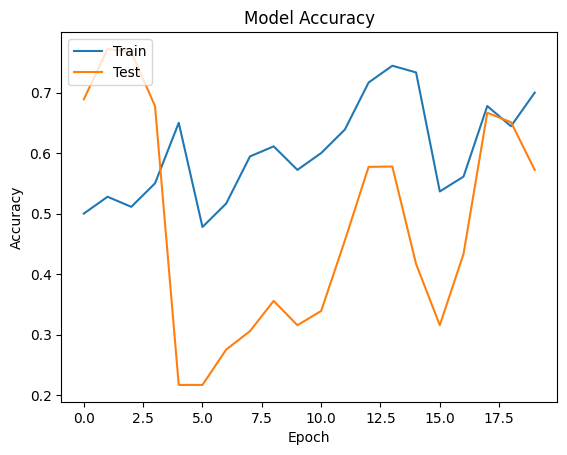

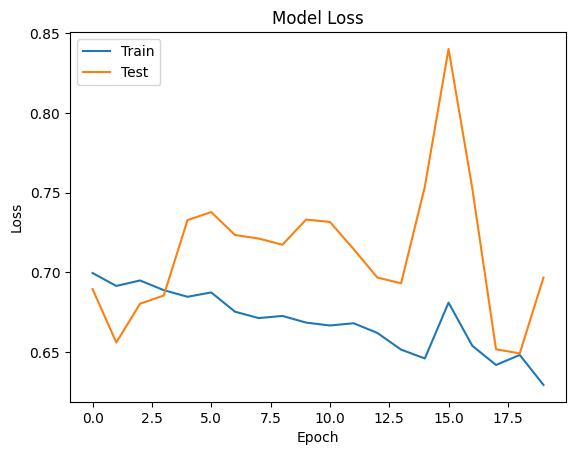

In [33]:
plot_loss_accuracy(history)

#### Model 4: 
Conv 2D Model with (32, 64, 128, 256) filters conv 2D layers + 128 dense layer + 128 dense layer + image size 120 by 120) with batch normalization

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau # Per ridurre il learning rate

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 118, 118, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,226,434 (4.68 MB)

 Trainable params: 1,225,474 (4.67 MB)

 Non-trainable params: 960 (3.75 KB)

In [35]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  # Puoi cambiarlo con un nome diverso per il tuo modello

In [36]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=40, 
    verbose=1,        
    callbacks=[callbacks_list, reduce_lr], 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    initial_epoch=0
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4852 - loss: 1.7863   
Epoch 1: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00001-1.66915-0.53889-0.78224-0.18889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4986 - loss: 1.7570 - val_accuracy: 0.1889 - val_loss: 0.7822 - learning_rate: 0.0010
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7185 - loss: 0.9234
Epoch 2: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00002-0.90429-0.70556-0.77767-0.15000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7153 - loss: 0.9186 - val_accuracy: 0.1500 - val_loss: 0.7777 - learning_rate: 0.0010
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7306 - loss: 0.6475
Epoch 3: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00003-0.61272-0.73333-0.83454-0.12222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7312 - loss: 0.6388 - val_accuracy: 0.1222 - val_loss: 0.8345 - learning_rate: 0.0010
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7528 - loss: 0.6322
Epoch 4: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00004-0.75900-0.73333-0.78074-0.43889.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7479 - loss: 0.6639 - val_accuracy: 0.4389 - val_loss: 0.7807 - learning_rate: 0.0010
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7481 - loss: 0.7748
Epoch 5: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00005-0.86232-0.74444-0.62286-0.77778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7472 - loss: 0.7967 - val_accuracy: 0.7778 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7944 - loss: 0.7278
Epoch 6: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00006-0.79263-0.76667-0.52578-0.81879.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7875 - loss: 0.7440 - val_accuracy: 0.8188 - val_loss: 0.5258 - learning_rate: 0.0010
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7630 - loss: 0.6106
Epoch 7: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00007-0.62624-0.75556-0.70407-0.65000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7611 - loss: 0.6145 - val_accuracy: 0.6500 - val_loss: 0.7041 - learning_rate: 0.0010
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6583 - loss: 0.8673
Epoch 8: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00008-0.74229-0.71667-0.78273-0.63333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6729 - loss: 0.8361 - val_accuracy: 0.6333 - val_loss: 0.7827 - learning_rate: 0.0010
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8056 - loss: 0.5828
Epoch 9: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00009-0.75775-0.75000-0.75006-0.78523.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7917 - loss: 0.6266 - val_accuracy: 0.7852 - val_loss: 0.7501 - learning_rate: 1.0000e-04
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7250 - loss: 1.0108
Epoch 10: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00010-0.90428-0.75000-0.77228-0.77222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7312 - loss: 0.9841 - val_accuracy: 0.7722 - val_loss: 0.7723 - learning_rate: 5.0000e-05
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7630 - loss: 0.7325
Epoch 11: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00011-0.66579-0.75556-0.86799-0.75000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7611 - loss: 0.7158 - val_accuracy: 0.7500 - val_loss: 0.8680 - learning_rate: 5.0000e-05
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7667 - loss: 0.5923
Epoch 12: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00012-0.66820-0.73333-0.84332-0.77181.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 2.5000001187436283e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7583 - loss: 0.6113 - val_accuracy: 0.7718 - val_loss: 0.8433 - learning_rate: 5.0000e-05
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7954 - loss: 0.5587
Epoch 13: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00013-0.68617-0.74444-0.91128-0.76667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7826 - loss: 0.5906 - val_accuracy: 0.7667 - val_loss: 0.9113 - learning_rate: 2.5000e-05
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7722 - loss: 0.6465
Epoch 14: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00014-0.64934-0.75000-1.00774-0.76111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7667 - loss: 0.6472 - val_accuracy: 0.7611 - val_loss: 1.0077 - learning_rate: 2.5000e-05
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7963 - loss: 0.5208
Epoch 15: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00015-0.57842-0.78889-0.93751-0.78333.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 1.2500000593718141e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7944 - loss: 0.5352 - val_accuracy: 0.7833 - val_loss: 0.9375 - learning_rate: 2.5000e-05
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7725 - loss: 0.5540   
Epoch 16: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00016-0.49243-0.80488-1.10153-0.75839.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7806 - loss: 0.5386 - val_accuracy: 0.7584 - val_loss: 1.1015 - learning_rate: 1.2500e-05
Epoch 17/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8176 - loss: 0.4263
Epoch 17: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00017-0.47843-0.81111-1.03000-0.78333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8160 - loss: 0.4394 - val_accuracy: 0.7833 - val_loss: 1.0300 - learning_rate: 1.2500e-05
Epoch 18/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8204 - loss: 0.5065
Epoch 18: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00018-0.49730-0.81111-1.02759-0.78889.h5



Epoch 18: ReduceLROnPlateau reducing learning rate to 6.250000296859071e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.8181 - loss: 0.5042 - val_accuracy: 0.7889 - val_loss: 1.0276 - learning_rate: 1.2500e-05
Epoch 19/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7602 - loss: 0.5824
Epoch 19: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00019-0.57582-0.75556-1.21168-0.75839.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7590 - loss: 0.5807 - val_accuracy: 0.7584 - val_loss: 1.2117 - learning_rate: 6.2500e-06
Epoch 20/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7546 - loss: 0.6174
Epoch 20: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00020-0.60890-0.75556-1.02298-0.80000.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.7549 - loss: 0.6153 - val_accuracy: 0.8000 - val_loss: 1.0230 - learning_rate: 6.2500e-06
Epoch 21/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7731 - loss: 0.6365
Epoch 21: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00021-0.57880-0.79444-1.17738-0.77778.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 3.1250001484295353e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7785 - loss: 0.6221 - val_accuracy: 0.7778 - val_loss: 1.1774 - learning_rate: 6.2500e-06
Epoch 22/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8130 - loss: 0.4205
Epoch 22: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00022-0.44103-0.80556-1.25036-0.77181.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8111 - loss: 0.4256 - val_accuracy: 0.7718 - val_loss: 1.2504 - learning_rate: 3.1250e-06
Epoch 23/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7574 - loss: 0.6970
Epoch 23: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00023-0.61306-0.77222-1.34258-0.76111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7611 - loss: 0.6760 - val_accuracy: 0.7611 - val_loss: 1.3426 - learning_rate: 3.1250e-06
Epoch 24/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8269 - loss: 0.4811
Epoch 24: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00024-0.43764-0.83889-1.49981-0.73889.h5



Epoch 24: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-06.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8299 - loss: 0.4702 - val_accuracy: 0.7389 - val_loss: 1.4998 - learning_rate: 3.1250e-06
Epoch 25/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8019 - loss: 0.5847
Epoch 25: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00025-0.62686-0.78889-1.58002-0.73333.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7986 - loss: 0.5952 - val_accuracy: 0.7333 - val_loss: 1.5800 - learning_rate: 1.5625e-06
Epoch 26/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7731 - loss: 0.5704
Epoch 26: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00026-0.59945-0.77778-1.29693-0.78523.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7743 - loss: 0.5777 - val_accuracy: 0.7852 - val_loss: 1.2969 - learning_rate: 1.5625e-06
Epoch 27/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7435 - loss: 0.7333
Epoch 27: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00027-0.66124-0.75556-1.27205-0.79444.h5



Epoch 27: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7465 - loss: 0.7153 - val_accuracy: 0.7944 - val_loss: 1.2721 - learning_rate: 1.5625e-06
Epoch 28/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8407 - loss: 0.4064
Epoch 28: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00028-0.44362-0.83889-1.59489-0.74497.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8403 - loss: 0.4157 - val_accuracy: 0.7450 - val_loss: 1.5949 - learning_rate: 7.8125e-07
Epoch 29/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7972 - loss: 0.4885
Epoch 29: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00029-0.50384-0.80000-1.31955-0.79444.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7979 - loss: 0.4923 - val_accuracy: 0.7944 - val_loss: 1.3195 - learning_rate: 7.8125e-07
Epoch 30/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8176 - loss: 0.5705
Epoch 30: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00030-0.53204-0.82778-1.56668-0.75839.h5



Epoch 30: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8201 - loss: 0.5609 - val_accuracy: 0.7584 - val_loss: 1.5667 - learning_rate: 7.8125e-07
Epoch 31/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8120 - loss: 0.4876
Epoch 31: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00031-0.48558-0.82778-1.58293-0.76111.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8160 - loss: 0.4871 - val_accuracy: 0.7611 - val_loss: 1.5829 - learning_rate: 3.9063e-07
Epoch 32/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8742 - loss: 0.3796  
Epoch 32: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00032-0.55005-0.81301-1.49124-0.77778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8589 - loss: 0.4222 - val_accuracy: 0.7778 - val_loss: 1.4912 - learning_rate: 3.9063e-07
Epoch 33/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7861 - loss: 0.7116
Epoch 33: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00033-0.66011-0.80000-1.51384-0.77852.h5



Epoch 33: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-07.
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7896 - loss: 0.6988 - val_accuracy: 0.7785 - val_loss: 1.5138 - learning_rate: 3.9063e-07
Epoch 34/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8556 - loss: 0.4341
Epoch 34: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00034-0.50130-0.83333-1.70841-0.75556.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8500 - loss: 0.4509 - val_accuracy: 0.7556 - val_loss: 1.7084 - learning_rate: 1.9531e-07
Epoch 35/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8213 - loss: 0.4262
Epoch 35: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00035-0.42934-0.82222-1.60383-0.77222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8215 - loss: 0.4269 - val_accuracy: 0.7722 - val_loss: 1.6038 - learning_rate: 1.9531e-07
Epoch 36/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6981 - loss: 0.7514
Epoch 36: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00036-0.75258-0.69444-1.77089-0.75168.h5



Epoch 36: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-08.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6972 - loss: 0.7517 - val_accuracy: 0.7517 - val_loss: 1.7709 - learning_rate: 1.9531e-07
Epoch 37/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8185 - loss: 0.5820
Epoch 37: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00037-0.55882-0.80556-1.62634-0.77778.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8153 - loss: 0.5762 - val_accuracy: 0.7778 - val_loss: 1.6263 - learning_rate: 9.7656e-08
Epoch 38/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7926 - loss: 0.5313
Epoch 38: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00038-0.55500-0.79444-1.66752-0.77222.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7931 - loss: 0.5373 - val_accuracy: 0.7722 - val_loss: 1.6675 - learning_rate: 9.7656e-08
Epoch 39/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7954 - loss: 0.6694
Epoch 39: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00039-0.71441-0.79444-1.77611-0.75839.h5



Epoch 39: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-08.
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7951 - loss: 0.6807 - val_accuracy: 0.7584 - val_loss: 1.7761 - learning_rate: 9.7656e-08
Epoch 40/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8370 - loss: 0.3939
Epoch 40: saving model to model_Conv2D_2_2025-05-05_21-13-55/model-00040-0.41525-0.82778-1.75850-0.76667.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8347 - loss: 0.3993 - val_accuracy: 0.7667 - val_loss: 1.7585 - learning_rate: 4.8828e-08


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


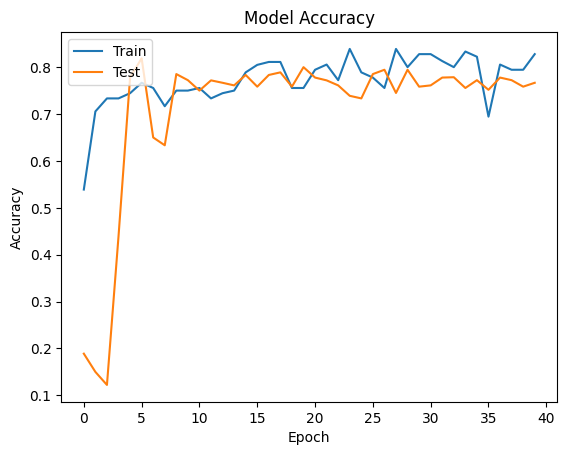

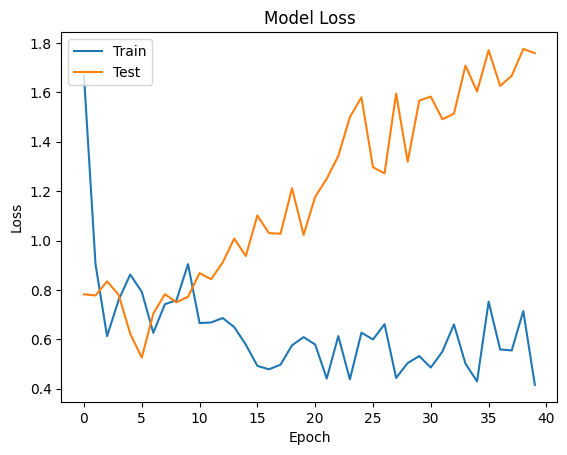

In [37]:
plot_loss_accuracy(history)


### TRANSFER LEARNING - MobileNet + DENSE

In [ ]:
def hand_segmentation_preprocessing(image):
    """Preprocessing per isolare la mano dallo sfondo"""
    # 1. Converti in HSV per segmentazione colore
    hsv = tf.image.rgb_to_hsv(image)
    
    # 2. Filtra per tonalità della pelle (regola questi valori)
    lower_skin = tf.constant([0.0, 0.2, 0.0], dtype=tf.float32)
    upper_skin = tf.constant([0.1, 1.0, 1.0], dtype=tf.float32)
    mask = tf.logical_and(
        tf.greater(hsv, lower_skin),
        tf.less(hsv, upper_skin))
    mask = tf.cast(mask, tf.float32)
    
    # 3. Applica la maschera e normalizza
    masked_image = image * mask
    normalized = masked_image / 255.0  # Normalizza a [0,1]
    
    return normalized

def robust_mobilenetv2_hand_classifier(input_shape=(120, 120, 3), num_classes=2):
    # Input layer con preprocessing
    inputs = Input(shape=input_shape)
    
    # Preprocessing personalizzato (solo durante il training)
    if tf.keras.backend.learning_phase():
        x = tf.keras.layers.Lambda(hand_segmentation_preprocessing)(inputs)
    else:
        x = inputs / 255.0  # Solo normalizzazione durante l'inferenza
    
    # Aggiungi augmentations per robustezza alla luce
    if tf.keras.backend.learning_phase():
        x = tf.keras.layers.RandomBrightness(0.3)(x)
        x = tf.keras.layers.RandomContrast(0.3)(x)
    
    # Base model
    base_model = MobileNetV2(
        input_tensor=x,
        weights='imagenet',
        include_top=False,
        alpha=0.35  # Versione più leggera (1.0 è la default)
    )
    
    # Fine-tuning configurabile
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Top model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model compilation
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#### Model 5: 
Mobilenet + DENSE

In [39]:
model = keras.applications.mobilenet.MobileNet()

print (model.summary())

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [40]:
callbacks_list = model_callbacks("model_mobilenet_dense")

steps_per_epoch, validation_steps = calculate_steps(len(train_doc), len(val_doc), batch_size)


train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [41]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None,
    initial_epoch=0
)

ValueError: You must call `compile()` before using the model.

In [ ]:
plot_loss_accuracy(history)

#### Model 6: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


def mobilenet_dense_variant(input_shape=(120, 120, 3), fine_tune=False, dense_nodes=128, dropout=0.3, num_classes=2):
    # Carica MobileNet senza il top (strati densi finali)
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Se non vogliamo fare fine-tuning, blocchiamo i pesi
    if not fine_tune:
        for layer in base_model.layers:
            layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Sostituisce Flatten per ridurre i parametri
        Dense(256, activation='relu'),
        Dropout(dropout),
        Dense(dense_nodes, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')  # Output finale
    ])

    # Compilazione del modello
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_dense_variant")

steps_per_epoch, validation_steps = calculate_steps(len(train_doc), len(val_doc), batch_size)


train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    initial_epoch=0
)

In [ ]:
plot_loss_accuracy(history)

#### Model 7: the one used for the model

In [ ]:
dropout = 0.1
regularization = 0.1

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Input shape per immagini 120x120
input_shape = (120, 120, 3)

# Carica MobileNet con input_shape corretto
base_model = MobileNet(include_top=False, input_shape=input_shape, weights='imagenet')
base_model.trainable = False  # Congela i pesi (puoi scegliere di fare fine-tuning)

# Costruzione del modello
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(regularization)),
    Dropout(dropout),
    Dense(128, activation='relu', kernel_regularizer=l2(regularization)),
    Dropout(dropout),
    Dense(2, activation='softmax')
])

# Compilazione del modello
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 3, 3, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,376,834 (12.88 MB)

 Trainable params: 147,970 (578.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [54]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5615 - loss: 36.0583
Epoch 1: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00001-35.37526-0.62917-32.95043-0.90909.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.5750 - loss: 35.9217 - val_accuracy: 0.9091 - val_loss: 32.9504 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7330 - loss: 32.6295
Epoch 2: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00002-31.97051-0.80417-30.12243-0.81818.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7472 - loss: 32.4977 - val_accuracy: 0.8182 - val_loss: 30.1224 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.8767 - loss: 29.4182
Epoch 3: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00003-28.85463-0.89583-27.00446-0.94258.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8806 - loss: 29.3055 - val_accuracy: 0.9426 - val_loss: 27.0045 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8872 - loss: 26.5012
Epoch 4: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00004-25.98218-0.88750-24.18380-0.95417.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8872 - loss: 26.3974 - val_accuracy: 0.9542 - val_loss: 24.1838 - learning_rate: 0.0010
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9094 - loss: 23.7901
Epoch 5: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00005-23.30096-0.91250-21.75086-0.90000.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9100 - loss: 23.6923 - val_accuracy: 0.9000 - val_loss: 21.7509 - learning_rate: 0.0010
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8955 - loss: 21.3697
Epoch 6: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00006-20.85396-0.90417-19.35201-0.93301.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 961ms/step - accuracy: 0.8972 - loss: 21.2666 - val_accuracy: 0.9330 - val_loss: 19.3520 - learning_rate: 0.0010
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9465 - loss: 18.8880
Epoch 7: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00007-18.51038-0.94167-17.18362-0.94737.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 845ms/step - accuracy: 0.9456 - loss: 18.8125 - val_accuracy: 0.9474 - val_loss: 17.1836 - learning_rate: 0.0010
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9299 - loss: 16.8420
Epoch 8: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00008-16.45696-0.94167-15.31197-0.95215.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 838ms/step - accuracy: 0.9322 - loss: 16.7650 - val_accuracy: 0.9522 - val_loss: 15.3120 - learning_rate: 0.0010
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9560 - loss: 15.0408
Epoch 9: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00009-14.71364-0.95628-13.67762-0.91388.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 868ms/step - accuracy: 0.9561 - loss: 14.9754 - val_accuracy: 0.9139 - val_loss: 13.6776 - learning_rate: 0.0010
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9542 - loss: 13.2958
Epoch 10: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00010-13.02375-0.95000-12.15132-0.91866.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 911ms/step - accuracy: 0.9533 - loss: 13.2414 - val_accuracy: 0.9187 - val_loss: 12.1513 - learning_rate: 0.0010
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9771 - loss: 11.8052
Epoch 11: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00011-11.57520-0.96667-10.75147-0.96172.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 990ms/step - accuracy: 0.9750 - loss: 11.7592 - val_accuracy: 0.9617 - val_loss: 10.7515 - learning_rate: 0.0010
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9715 - loss: 10.4736
Epoch 12: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00012-10.24942-0.97500-9.56312-0.97608.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9722 - loss: 10.4288 - val_accuracy: 0.9761 - val_loss: 9.5631 - learning_rate: 0.0010
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9490 - loss: 9.3723
Epoch 13: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00013-9.15139-0.96250-8.59838-0.91388.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 881ms/step - accuracy: 0.9517 - loss: 9.3281 - val_accuracy: 0.9139 - val_loss: 8.5984 - learning_rate: 0.0010
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9497 - loss: 8.3400
Epoch 14: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00014-8.15745-0.95417-7.57308-0.97917.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 884ms/step - accuracy: 0.9506 - loss: 8.3035 - val_accuracy: 0.9792 - val_loss: 7.5731 - learning_rate: 0.0010
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9934 - loss: 7.4014
Epoch 15: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00015-7.25710-0.98750-6.76520-0.97917.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 974ms/step - accuracy: 0.9922 - loss: 7.3725 - val_accuracy: 0.9792 - val_loss: 6.7652 - learning_rate: 0.0010
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9583 - loss: 6.6659
Epoch 16: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00016-6.51749-0.96667-6.12483-0.94583.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 990ms/step - accuracy: 0.9600 - loss: 6.6362 - val_accuracy: 0.9458 - val_loss: 6.1248 - learning_rate: 0.0010
Epoch 17/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9490 - loss: 6.0067
Epoch 17: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00017-5.88807-0.94583-5.46213-0.97129.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 876ms/step - accuracy: 0.9483 - loss: 5.9830 - val_accuracy: 0.9713 - val_loss: 5.4621 - learning_rate: 0.0010
Epoch 18/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9691 - loss: 5.3874
Epoch 18: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00018-5.26987-0.97083-4.92425-0.97129.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 862ms/step - accuracy: 0.9694 - loss: 5.3639 - val_accuracy: 0.9713 - val_loss: 4.9243 - learning_rate: 0.0010
Epoch 19/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9729 - loss: 4.8114
Epoch 19: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00019-4.70132-0.98333-4.47488-0.94737.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 935ms/step - accuracy: 0.9750 - loss: 4.7894 - val_accuracy: 0.9474 - val_loss: 4.4749 - learning_rate: 0.0010
Epoch 20/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9656 - loss: 4.3686
Epoch 20: saving model to model_mobilenet_dense_2025-05-05_21-18-26/model-00020-4.27333-0.97083-4.02184-0.96172.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9667 - loss: 4.3496 - val_accuracy: 0.9617 - val_loss: 4.0218 - learning_rate: 0.0010


Chiavi disponibili in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


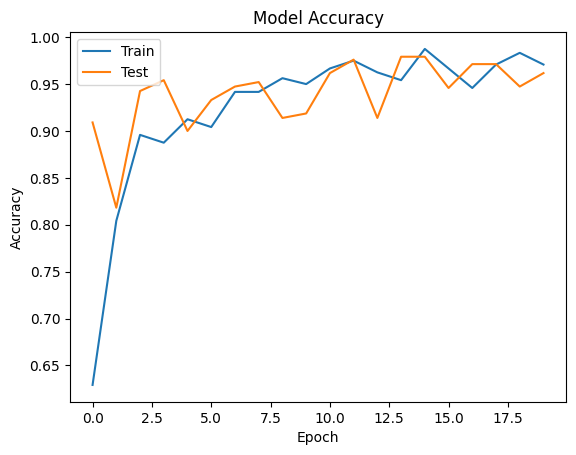

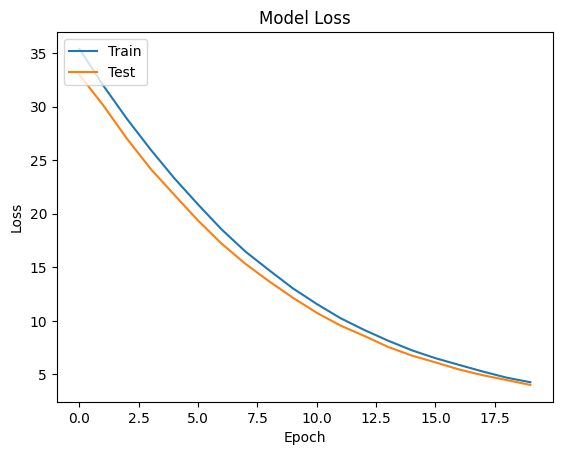

In [55]:
plot_loss_accuracy(history)